In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(14*1)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [16]:
client

<Client: 'tcp://10.148.0.223:59670' processes=14 threads=14, memory=239.96 GB>

________________

# RMS of Tau


In [6]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/rms/'

In [7]:
# read rechunked data
grid = xr.open_zarr(out_dir_zarr+'grid.zarr')
ds_TAUX = xr.open_zarr(out_dir_zarr+'oceTAUX.zarr').rename({'i_g': 'i'}).isel(time=slice(0,None,24))
ds_TAUY = xr.open_zarr(out_dir_zarr+'oceTAUY.zarr').rename({'j_g': 'j'}).isel(time=slice(0,None,24))

# data merge
ds = xr.merge([ds_TAUX,ds_TAUY,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 358)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(9,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-14T08:00:00
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
 

In [8]:
# coriolis term
lat = ds['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))
f_ij

<xarray.DataArray 'YC' (face: 13, j: 4320, i: 4320)>
dask.array<mul, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

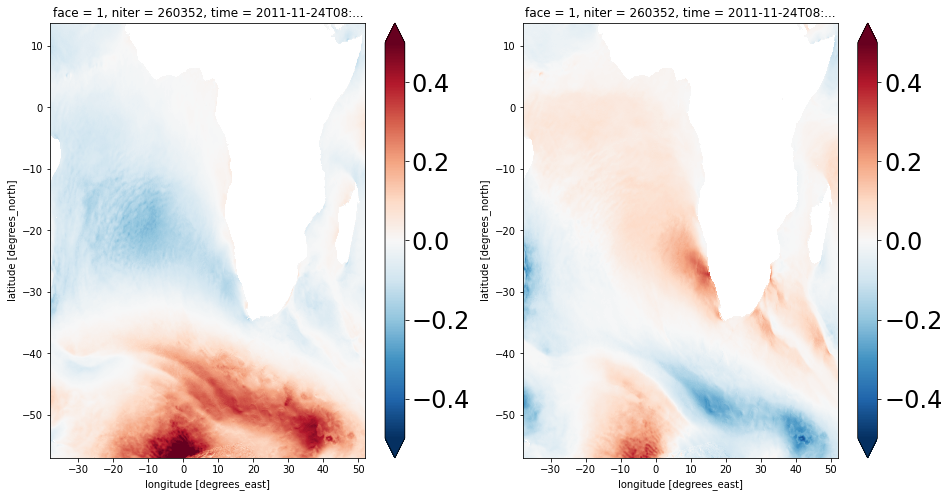

In [10]:

fig, ax = plt.subplots(figsize=(24,8))

ax = plt.subplot(131)
cax = (ds.oceTAUX.isel(face=1).sel(time='2011-11-24T08:00:00')).plot(x='XC', y='YC', cmap = 'RdBu_r', vmin=-0.5, vmax=0.5, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('', fontsize=24)

ax = plt.subplot(132)
cax = (ds.oceTAUY.isel(face=1).sel(time='2011-11-24T08:00:00')).plot(x='XC', y='YC', cmap = 'RdBu_r', vmin=-0.5, vmax=0.5, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('', fontsize=24)


In [17]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'RMS_Tau_ELD_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:
        
        oceTAUX_rotation =  ds.oceTAUX.isel(face=face)*ds.CS.isel(face=face) - ds.oceTAUY.isel(face=face)*ds.SN.isel(face=face)
        oceTAUY_rotation =  ds.oceTAUX.isel(face=face)*ds.SN.isel(face=face) + ds.oceTAUY.isel(face=face)*ds.CS.isel(face=face)

        
        # tau
        oceTAU_rms = np.sqrt( ( (oceTAUX_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4)))**2 + (oceTAUY_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4)))**2 ).mean(['time']))
        chunks = {'i': 108, 'j': 108}
        oceTAU_rms = oceTAU_rms.chunk(chunks)        
        oceTAU_rms = np.real(oceTAU_rms).rename('oceTAU_rms')
        
        # Ekman layer depth
        tau = np.sqrt(oceTAUX_rotation**2 + oceTAUY_rotation**2)
        u_friction = np.sqrt(tau/1025)
        ELD = 0.2*u_friction/np.abs(f_ij.isel(face=face))
        #ELD = 0.2*np.sqrt(np.sqrt(oceTAUX_rotation**2 + oceTAUY_rotation**2)/1025)/np.abs(f_ij.isel(face=face))
        ELD_rms = np.sqrt( ((ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4)))**2 ).mean(['time']))
        chunks = {'i': 108, 'j': 108}
        ELD_rms = ELD_rms.chunk(chunks)        
        ELD_rms = np.real(ELD_rms).rename('ELD_rms')         
        
        # tau_x/ELD/rho
        oceTAUX_ELD_rms =  np.sqrt( ((oceTAUX_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025)**2).mean(['time']) )
        #chunks = {'i': 108, 'j': 108}
        #oceTAUX_ELD_rms = oceTAUX_ELD_rms.chunk(chunks)
        #oceTAUX_ELD_rms = np.real(oceTAUX_ELD_rms).rename('oceTAUX_ELD_rms')
        
        # tau_y/ELD/rho
        oceTAUY_ELD_rms = np.sqrt(( (oceTAUY_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025 )**2 ).mean(['time']))
        #chunks = {'i': 108, 'j': 108}
        #oceTAUY_ELD_rms = oceTAUY_ELD_rms.chunk(chunks)        
        #oceTAUY_ELD_rms = np.real(oceTAUY_ELD_rms).rename('oceTAUY_ELD_rms')        
        
        
        Tau_ELD_rms = np.sqrt(oceTAUX_ELD_rms**2 + oceTAUY_ELD_rms**2)
        chunks = {'i': 108, 'j': 108}
        Tau_ELD_rms = Tau_ELD_rms.chunk(chunks)        
        Tau_ELD_rms = np.real(Tau_ELD_rms).rename('Tau_ELD_rms')       
        
        
        rms_all = xr.merge([oceTAU_rms, ELD_rms, Tau_ELD_rms])
        
        for c in rms_all.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time rms_all.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 14 s, sys: 708 ms, total: 14.7 s
Wall time: 39.7 s
--- face 0 done
CPU times: user 13.7 s, sys: 808 ms, total: 14.5 s
Wall time: 38.7 s
--- face 1 done
CPU times: user 13.5 s, sys: 560 ms, total: 14 s
Wall time: 37.8 s
--- face 2 done
CPU times: user 13.6 s, sys: 588 ms, total: 14.2 s
Wall time: 36.8 s
--- face 3 done
CPU times: user 13.7 s, sys: 780 ms, total: 14.4 s
Wall time: 39.1 s
--- face 4 done
CPU times: user 13.5 s, sys: 500 ms, total: 14 s
Wall time: 36.3 s
--- face 5 done
CPU times: user 13.6 s, sys: 588 ms, total: 14.2 s
Wall time: 38.7 s
--- face 6 done
CPU times: user 13.8 s, sys: 680 ms, total: 14.5 s
Wall time: 38.9 s
--- face 7 done
CPU times: user 13.8 s, sys: 576 ms, total: 14.4 s
Wall time: 39 s
--- face 8 done
CPU times: user 13.8 s, sys: 624 ms, total: 14.4 s
Wall time: 38.3 s
--- face 9 done
CPU times: user 15.1 s, sys: 548 ms, total: 15.7 s
Wall time: 42.9 s
--- face 10 done
CPU times: user 14.6 s, sys: 632 ms, total: 15.3 s
Wall time: 39.9 s
---

____________
# Read RMS

In [18]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
ice = xr.open_zarr(out_dir_zarr+'sea_ice_mask.zarr').isel(j=slice(0 ,None, 4), i=slice(0, None, 4))
ice

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
Data variables:
    AREA     (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [19]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/rms/'
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(store_dir_zarr+'RMS_Tau_ELD_f%02d.zarr'%(face)) for face in face_all] 
ds_TAU = xr.concat(D, dim='face')
print(ds_TAU) 
print('\n data size: %.1f GB' %(ds_TAU.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (face: 13, i: 1080, j: 1080)
Coordinates:
  * i            (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j            (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    CS           (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    Depth        (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    SN           (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    XC           (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    YC           (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
  * face         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    rA           (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
Data variables:
    ELD_rms      (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    Tau_ELD_rms  (face, j, i) float32 dask.array<chunk

In [29]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>=0) & (vplt.XC<=180.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where(vplt.XC<=0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 1e-5, 2e-5, 3e-5,4e-5])
        cb.ax.set_yticklabels(['0','1','2','3','4'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
        ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

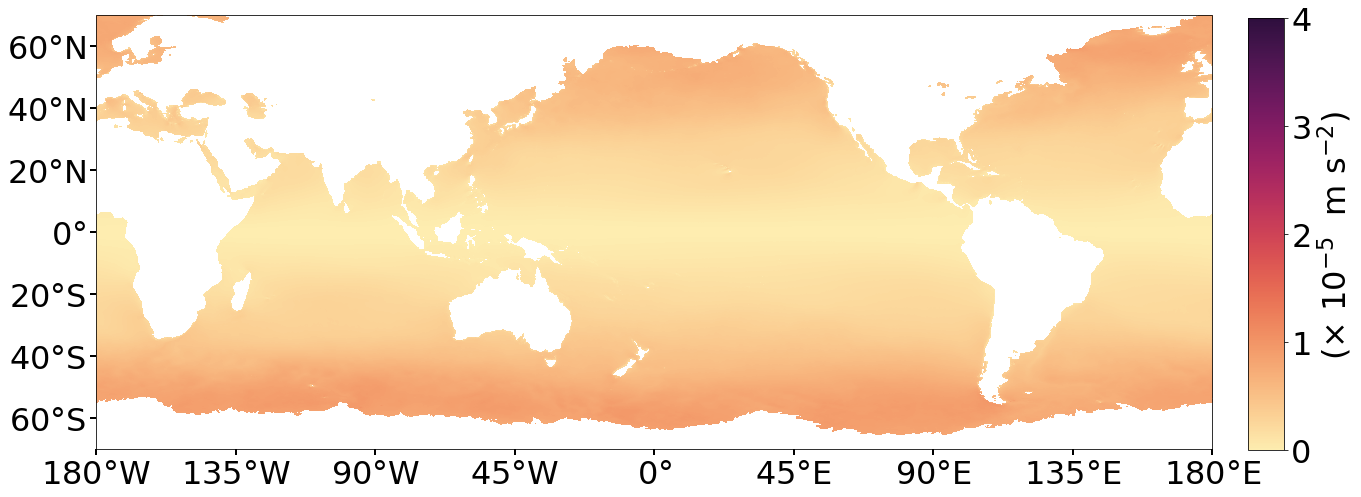

In [16]:
# vertical stress divergence
plot_pretty(Tau_ELD_rms.where(ice.AREA>0), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=4e-5, cmmap='matter', ignore_face=[6])

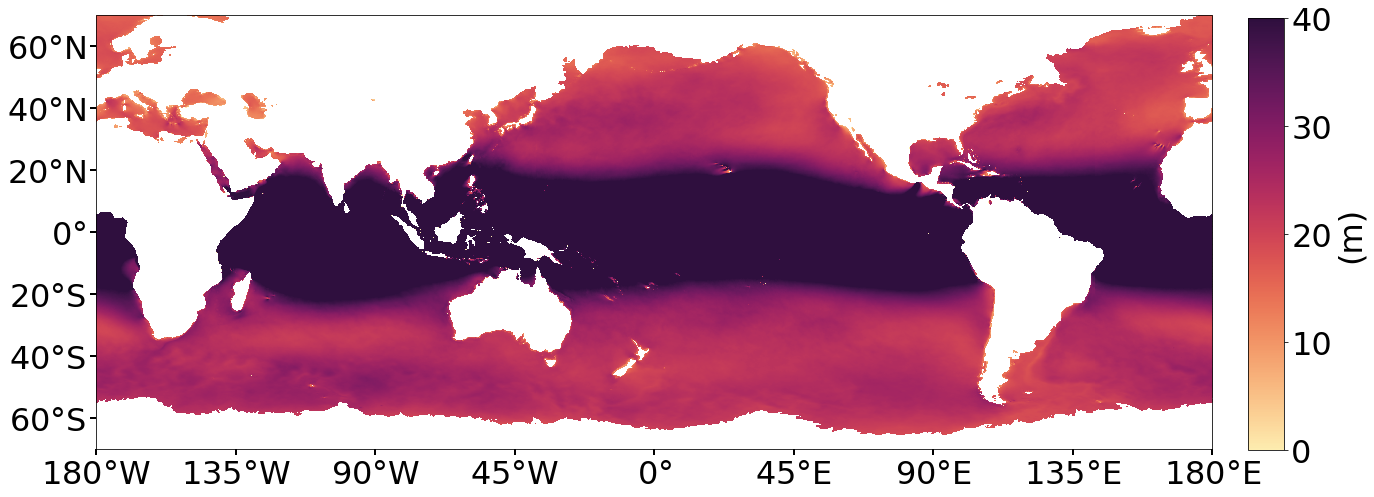

In [16]:
# Ekman layer depth
plot_pretty(ds_TAU.ELD_rms.where(ice.AREA>0), label='(m)', vmin=0, vmax=40, cmmap='matter', ignore_face=[6])

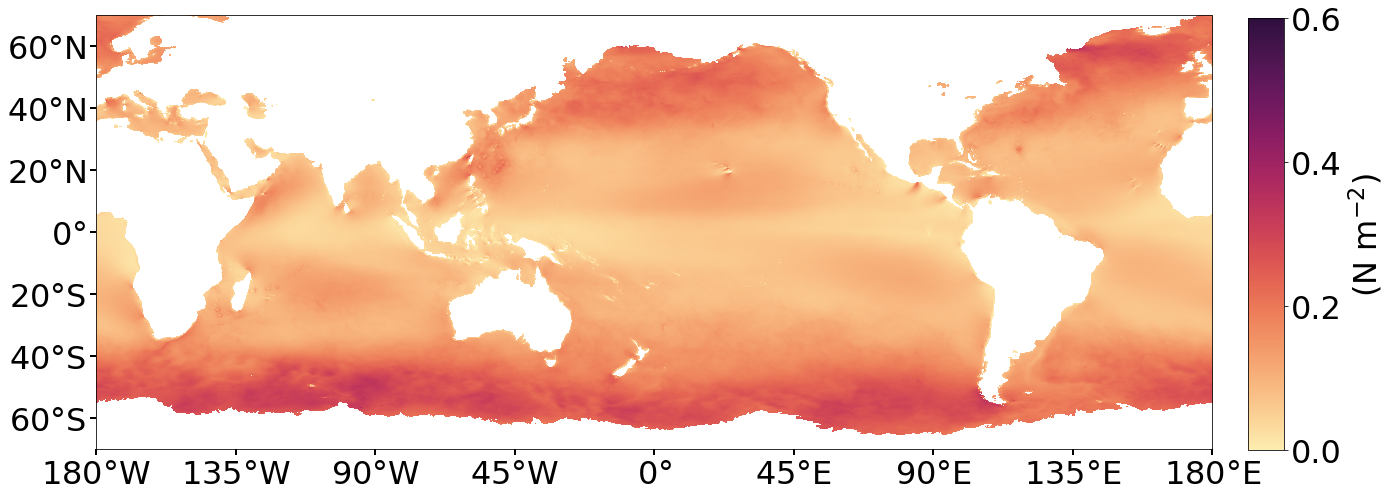

In [35]:
# Tau
plot_pretty(ds_TAU.oceTAU_rms.where(ice.AREA>0), label=r'(N m$^{-2}$)', vmin=0, vmax=0.6, cmmap='matter', ignore_face=[6])

______________
# Save as a .nc file to tranfer to hal

In [36]:
print(ds_TAU) 

<xarray.Dataset>
Dimensions:      (face: 13, i: 1080, j: 1080)
Coordinates:
  * i            (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j            (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    CS           (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    Depth        (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    SN           (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    XC           (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    YC           (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
  * face         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    rA           (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
Data variables:
    ELD_rms      (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    Tau_ELD_rms  (face, j, i) float32 dask.array<chunk

In [37]:
file_out = store_dir_zarr+'/Tau_ELD_rms.nc'
%time ds_TAU.to_netcdf(file_out, mode='w')   

CPU times: user 2min 23s, sys: 5.44 s, total: 2min 28s
Wall time: 10min 4s


In [39]:
cluster.close()